In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
import ast
import numpy as np
%matplotlib inline

# Table of Contents
    1. Import data, initial cleaning and feature engineering
        1.1 Import data
        1.2 Correct datatypes
        1.3 Fill in missing Spotify data
        1.4 Preliminary feature engineering
    2. Summary statistics on continuous data (Ticket prices, times)
        2.1 Summary Statistics
        2.2 Histograms
        2.3 ECDFs
        2.4 Conclusions & Questions
    3. Outlier detection
        3.1 Define find_outlier function
        3.2 Count number of outliers
        3.3 Conclusions & questions
    4. Summary of categorical features
        4.1 Events by state
        4.2 Events by genre
        4.3 Events by promoter
        4.4 Events by month
        4.5 Events with multiple days
        4.6 Conclusions & questions

## 1.1 Import data

In [2]:
#Read master dataframe, parsing 
path = 'Data/master_df.csv'
df = pd.read_csv(path,
                 parse_dates=['presale_date_end','presale_date_start','date','TM_sale_date_start'],
                 infer_datetime_format=True)

## 1.2 Correct datatypes

In [3]:
df.dtypes

Unnamed: 0                     int64
artists                       object
date                  datetime64[ns]
TM_id                         object
event_title                   object
presale_date_end      datetime64[ns]
presale_date_start    datetime64[ns]
promoter                      object
TM_sale_date_start    datetime64[ns]
span multiple days              bool
venue                         object
TM_venue _lat                 object
venue_city                    object
TM_venue_long                 object
venue_state                   object
TM_max                       float64
TM_min                       float64
genre                         object
subGenre                      object
event_type                    object
SG_artists_score              object
SG_average_price              object
SG_listing_count              object
SG_max_price                  object
SG_min_price                  object
SG_venue_score               float64
SH_max_price                 float64
S

In [4]:
#Convert data types to floats and replace 'None' with NaN
df[['SG_min_price','SG_max_price','SG_average_price','SG_listing_count']] = \
     df[['SG_min_price','SG_max_price','SG_average_price','SG_listing_count']].replace('None',np.NaN)
df[['SG_min_price','SG_max_price','SG_average_price','SG_listing_count']] = \
    df[['SG_min_price','SG_max_price','SG_average_price','SG_listing_count']].astype(float)

## 1.3 Fill in missing Spotify info with genre medians

In [5]:
# Parse to lists as convert elements to float
def format_spotify_data(cell):
    #Parse list
    cell = ast.literal_eval(cell)
    #Convert to float types
    cell= list(map(float, cell))
    return cell

#Parse strings into lists, convert elements to float
df[['spotify_followers','spotify_popularity']] = df[['spotify_followers','spotify_popularity']].applymap(format_spotify_data)

#Calculate averages for each event
df[['spotify_avg_followers','spotify_avg_popularity']] = df[['spotify_followers','spotify_popularity']].applymap(np.nanmean)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:5043: RuntimeWarning: Mean of empty slice
  return lib.map_infer(x.asobject, func)


In [6]:
#Create dictionaries of genres and median values
popularity_dict = dict(df[['genre','spotify_avg_popularity']].groupby('genre').median())
followers_dict = dict(df[['genre','spotify_avg_followers']].groupby('genre').median())

In [7]:
#Map dictionaries to fill in missing values
mask = df['spotify_avg_popularity'].isnull()
df.loc[mask,'spotify_avg_popularity'] = df.loc[mask,'genre'].map(popularity_dict)

mask = df['spotify_avg_followers'].isnull()
df.loc[mask,'spotify_avg_followers'] = df.loc[mask,'genre'].map(popularity_dict)

df[['spotify_avg_followers','spotify_avg_popularity']] = df[['spotify_avg_followers','spotify_avg_popularity']].astype(float)

#Create column with count of null artist info
df['spotify_null_count'] = df['spotify_popularity'].map(lambda x: np.isnan(x).sum())

## 1.4 Preliminary feature engineering

In [8]:
# Create relevant columns based on datetime information

#Create Timestamp of December 7, 2017 -- Date of analysis
day_zero = pd.Timestamp(datetime.datetime(2017, 12, 7))
df['days_until_show'] = (df['date'] - day_zero).dt.days

#Length of presale
df['presale_length'] = (df['presale_date_end'] - df['presale_date_start']).dt.days

# of days show has been on sale
df['days_on_sale'] = (day_zero-df['TM_sale_date_start']).dt.days

In [9]:
df.columns

Index(['Unnamed: 0', 'artists', 'date', 'TM_id', 'event_title',
       'presale_date_end', 'presale_date_start', 'promoter',
       'TM_sale_date_start', 'span multiple days', 'venue', 'TM_venue _lat',
       'venue_city', 'TM_venue_long', 'venue_state', 'TM_max', 'TM_min',
       'genre', 'subGenre', 'event_type', 'SG_artists_score',
       'SG_average_price', 'SG_listing_count', 'SG_max_price', 'SG_min_price',
       'SG_venue_score', 'SH_max_price', 'SH_min_price', 'SH_total_postings',
       'SH_total_tickets', 'spotify_followers', 'spotify_popularity',
       'spotify_avg_followers', 'spotify_avg_popularity', 'spotify_null_count',
       'days_until_show', 'presale_length', 'days_on_sale'],
      dtype='object')

# 2 Summary Statistics
    2.1 Summary Stats
    2.2 Histograms
    2.3 ECDFs
    2.4 Conclusions & Questions

## 2.1 Summary Stats

In [10]:
price_cols = ['TM_min','SH_min_price','SG_min_price','TM_max','SH_max_price','SG_max_price']
df[price_cols].describe()

,TM_min,SH_min_price,SG_min_price,TM_max,SH_max_price,SG_max_price
count,5102.000000,3283.000000,2857.000000,5102.000000,3.283000e+03,2.857000e+03
mean,36.957909,108.823408,72.952048,95.494120,6.613995e+03,1.487126e+03
std,21.849023,228.443835,47.970814,216.077366,2.126984e+05,2.262061e+04
min,2.500000,9.700000,6.000000,5.000000,2.578000e+01,2.300000e+01
25%,24.000000,56.630000,45.000000,28.500000,1.213000e+02,4.340000e+02
50%,33.500000,76.580000,61.000000,57.500000,3.025000e+02,5.290000e+02
75%,45.000000,101.760000,86.000000,99.000000,8.383000e+02,5.780000e+02
max,675.000000,3602.500000,588.000000,9691.000000,1.200000e+07,1.204002e+06


In [11]:
time_cols = ['days_on_sale','days_until_show','presale_length']
df[time_cols].describe()

,days_on_sale,days_until_show,presale_length
count,5019.000000,5102.000000,3509.000000
mean,61.597330,77.437475,17.602166
std,60.091337,58.077022,49.206099
min,-30.000000,0.000000,0.000000
25%,19.000000,35.000000,1.000000
50%,48.000000,70.000000,1.000000
75%,82.000000,108.000000,2.000000
max,538.000000,367.000000,344.000000


## 2.2 Histograms

Try different methodologiegs for histogram binning, in this case the Rice method appears best <br>
__Reference:__ https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width

In [12]:
#Define functions for various ways of calculating bin sizes to determine best
sqrt_bins = lambda x: math.ceil(math.sqrt(df[x].count()))
scotts_bins = lambda x: math.ceil((3.5 * df[x].std())/(df[x].count())**(1/3))
rice_bins = lambda x: math.ceil(2*df[x].count()**(1/3) )

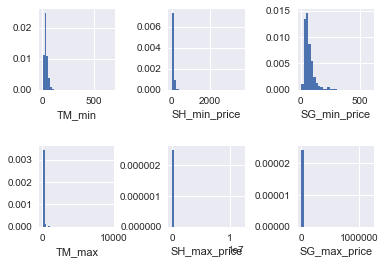

In [13]:
#Set plot style to seaborn
sns.set()
# Plot histogram of ticket prices

#Set initial subplot number
plot = 1

#Loop through each price column
for col in price_cols:
    plt.subplot(2,3,plot)
    plt.hist(df[col].dropna(),
             bins = rice_bins(col),
             normed=True
            )
    plt.xlabel(col)
    plot +=1
    
plt.subplots_adjust(hspace=.7,wspace=0.7)
plt.show()


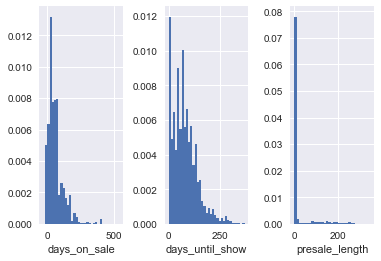

In [14]:
#Show histograms of time info
plot = 1
for col in time_cols:
    plt.subplot(1,3,plot)
    plt.hist(df[col].dropna(),
             bins = rice_bins(col),
             normed=True)
    plt.xlabel(col)
    plot +=1
plt.subplots_adjust(hspace=.7,wspace=0.5)
plt.show()

## 2.3 ECDFs

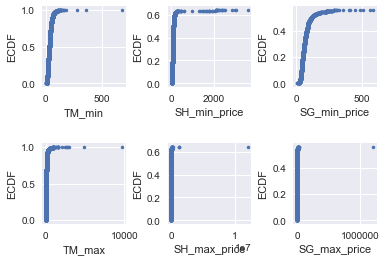

In [15]:
#Define ECDF Function
def plot_ecdf(data,label):
    x = np.sort(data)
    y = np.arange(1,len(x)+1)/float(len(x))
    
    #Make plot
    plot = plt.plot(x, y,label=label,marker='.',linestyle='none')
    plt.xlabel(label)
    plt.ylabel('ECDF')
    
    return plot

plot = 1
for col in price_cols:
    plt.subplot(2,3,plot) 
    plot_ecdf(df[col],col)
    plot += 1

plt.subplots_adjust(hspace=.7,wspace=0.5)
plt.show()

## Conclusions & Questions:
    -Lots of outliers, especially among ticket prices maximums
    -Data should be transformed or outliers should be removed
    -Why is ECDF range only going to .6?

# 3 Outlier Detection
    3.1 Define find_outlier function
    3.2 Count number of outliers
    3.3 Conclusions & questions
## 3.1 Define functions
Detect outliers using Tukey method of +/- 1.5IQR range

In [16]:
def find_outliers(df, column,threshold=1.5):
    q1, q3 = df[column].quantile([.25,.75])
    iqr = np.subtract(q3,q1)
    lower_bound = q1 - (iqr * threshold)
    upper_bound = q3 + (iqr* threshold)
    return df.loc[(df[column] > upper_bound) | (df[column] < lower_bound)]

## 3.2 Define number of outliers

In [17]:
outlier_list = list()
for col in price_cols:
    outlier_list.append(find_outliers(df,col))
outlier_df = pd.concat(outlier_list,axis=0)
outlier_df['TM_id'].nunique()

1459

## 3.3 Conclusion & questions
Removing all ouliers would remove a large portion of the data. <br>
__What should we do instead?__

# 4 Plots of various features
    4.1 Events by state
    4.2 Events by genre
    4.3 Events by promoter
    4.4 Events by month
    4.5 Events with multiple days
    
 ## 4.1 Events by state

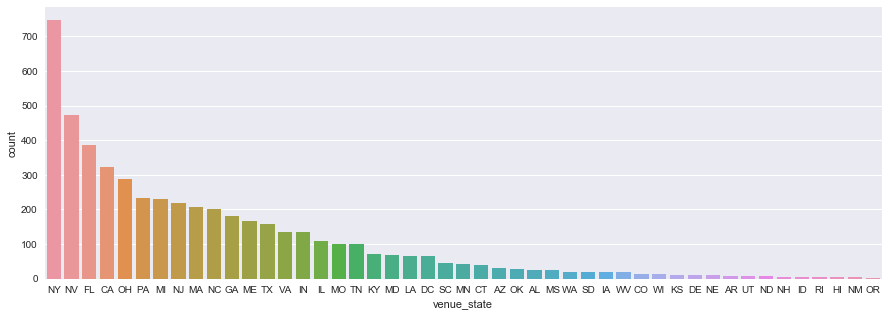

In [18]:
#Events by State
fig = plt.figure(figsize=(15,5))
sns.countplot(data=df,x='venue_state', order = df['venue_state'].value_counts().index)
plt.show()

## 4.2 Events by genre

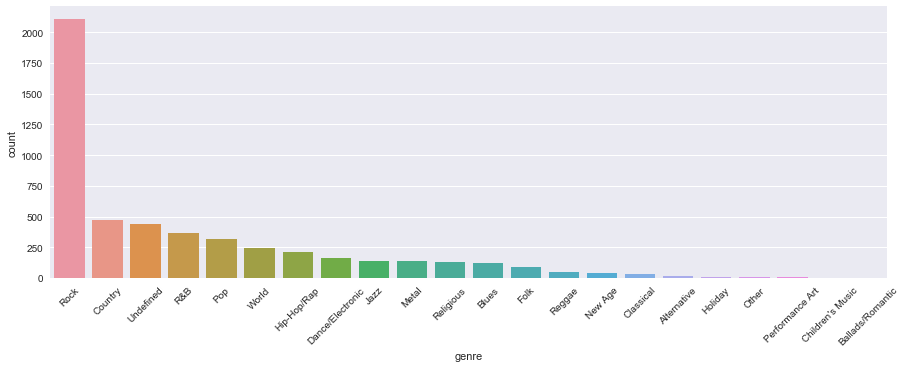

In [19]:
#Events by genre
plt.figure(figsize=(15,5))
sns.countplot(x='genre',data=df,order=df['genre'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

## 4.3 Events by promoter

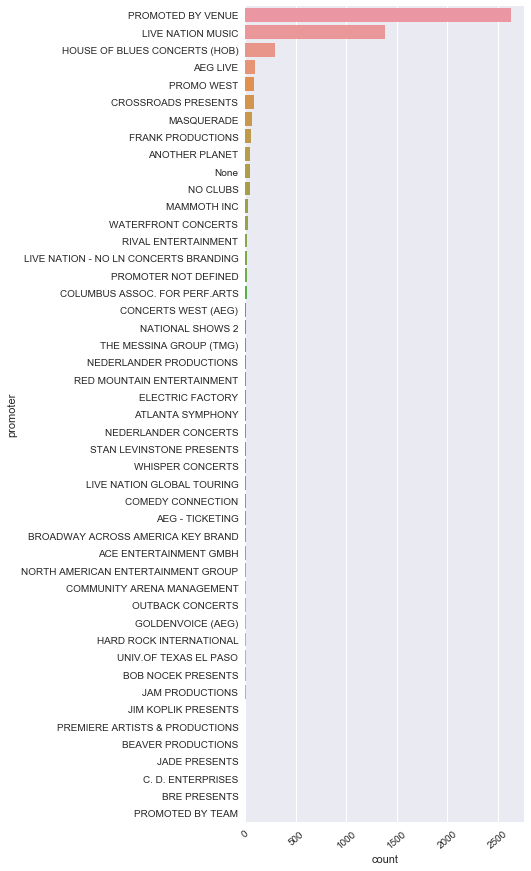

In [20]:
# Events by promoter
fig = plt.figure(figsize=(5,15))
sns.countplot(y='promoter',data=df,order=df['promoter'].value_counts().index)
plt.xticks(rotation=40)
plt.show()

## 4.4 Events by Month

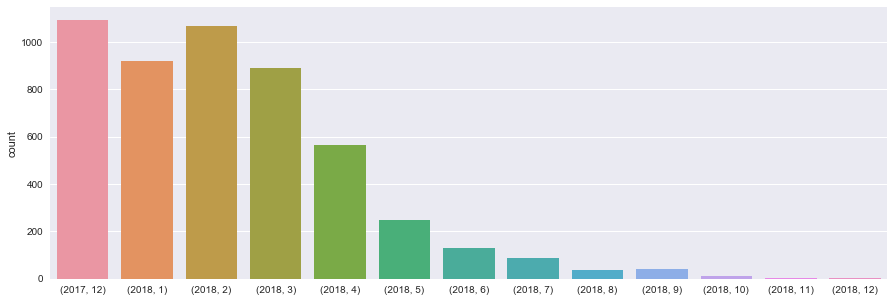

In [21]:
#Create list of Year & Months
year_month = list(zip(df["date"].dt.year, df["date"].dt.month))
# Sort by year, then month, convert to series for plotting
year_month = pd.Series(sorted(year_month,key=lambda x: (x[0], x[1])))

#Events by month
fig = plt.figure(figsize=(15,5))
sns.countplot(year_month)
plt.show()

## 4.5 Events by length

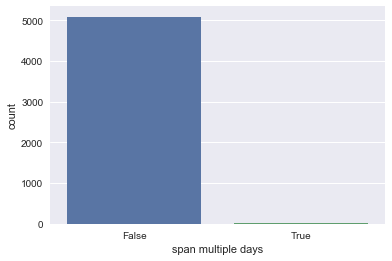

In [22]:
sns.countplot(x='span multiple days',data=df)
plt.show()

## 4.6 Conclusions
__Should we remove features with few values?__ <br>
__What should the threshold be for count of samples in a category to keep it?__
    1. Span Multiple Days
    2. Promoter
    3. States with only a few events

# 5. Final thoughts & questions
__1. Dealing with outliers & noise__<br>
    There is a lot variation and noise, especiall in maximum prices. Should we apply a transformation or address outliers? <br>
__2. Comparing ticket price values__ <br>
    Should we compare TM min prices to resale mins, and TM max prices resale max prices, or average the min and max values?<br>
__3. Reducing features and categories__ <br>
    Should we remove categories with few samples of data (states with a few shows, genres with few events, etc.)?


In [25]:
#Save DF to csv and pickle
df.to_csv('Data/cleaned_df.csv',index=False)
df.to_pickle('Pickles/cleaned_df.pkl')